# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### Общая информация
Дата выдачи: 05.10.2019

Мягкий дедлайн: 07:59MSK 15.10.2019 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 23:59MSK 17.10.2019

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. 

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

## Реализация градиентного спуска

Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью:

** Задание 1 (1 балл)** Градиентного спуска;

** Задание 2 (1.5 балла)** Стохастического градиентного спуска;

** Задание 3 (2.5 балла)** Метода Momentum.


Во всех пунктах необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускается использовать только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):

    * проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
    * достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).
* Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);
* Инициализировать веса можно случайным образом или нулевым вектором. 


Ниже приведён шаблон класса, который должен содержать код реализации каждого из методов.

In [1]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [69]:
class LinearReg(BaseEstimator):
    def __init__(self, gd_type='stochastic', 
                 tolerance=1e-6, max_iter=1000, w0=0, alpha=1e-3, eta=1e-2, random_state=1, batch_size=1):
        """
        gd_type: 'full' or 'stochastic' or 'momentum'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = [] # list of loss function values at each training iteration
        
        self.random_state = random_state
        self.batch_size = batch_size
    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        rgen = np.random.RandomState(self.random_state)
        self.w = rgen.normal(loc=0, scale=0.1, size=X.shape[1])
        self.loss_history.append(self.calc_loss(X, y))
        
        
        if self.gd_type == 'full':
            for i in range(self.max_iter):
                w0_grad, w_grad = self.calc_gradient(X, y)

                self.w0 += self.eta * w0_grad
                self.w += self.eta * w_grad
                self.loss_history.append(self.calc_loss(X, y))

                if np.abs(self.loss_history[-1] - self.loss_history[-2]) < self.tolerance:
                    break
        
        elif self.gd_type == 'stochastic':
            for i in range(self.max_iter):
                
                for (X_batch, y_batch) in self.next_batch(X, y):   
                    w0_grad, w_grad = self.calc_gradient(X_batch, y_batch)
                    self.w0 += self.eta * w0_grad
                    self.w += self.eta * w_grad
                
#                 index = np.random.randint(0, X.shape[0], size=self.batch_size)
                
#                 w0_grad, w_grad = self.calc_gradient(X[index], y[index])

#                 self.w0 += self.eta * w0_grad
#                 self.w += self.eta * w_grad
                
                self.loss_history.append(self.calc_loss(X, y))

                if np.abs(self.loss_history[-1] - self.loss_history[-2]) < self.tolerance:
                    break
        
        
        elif self.gd_type == 'momentum':
            for i in range(self.max_iter):
                
#                 index = np.random.randint(0, X.shape[0], size=self.batch_size)
#                 w0_grad, w_grad = self.calc_gradient(X[index], y[index])

                if i == 0:
                    w0_velocity = 0
                    w_velocity = np.zeros_like(self.w)

                for (X_batch, y_batch) in self.next_batch(X, y):   
                    w0_grad, w_grad = self.calc_gradient(X_batch, y_batch)
                    
#                     self.w0 += self.eta * w0_grad
#                     self.w += self.eta * w_grad
                    
                    w0_velocity = self.alpha * w0_velocity + self.eta * w0_grad
                    w_velocity = self.alpha * w_velocity + self.eta * w_grad
                    self.w0 += w0_velocity
                    self.w += w_velocity
    
                
                
                w0_velocity = self.alpha * w0_velocity + self.eta * w0_grad
                w_velocity = self.alpha * w_velocity + self.eta * w_grad
                self.w0 += w0_velocity
                self.w += w_velocity
                
                self.loss_history.append(self.calc_loss(X, y))

                if np.abs(self.loss_history[-1] - self.loss_history[-2]) < self.tolerance:
                    break
            
        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        
        predict = np.dot(X, self.w) + self.w0
        return predict
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        
        predicitons = self.predict(X)
        error = (y - predicitons)
        
        w0_grad = error.sum()
        w_grad = X.T.dot(error)
        
        return w0_grad, w_grad

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        
        predictions = self.predict(X)
        return np.sum(np.square(y-predictions))/y.shape[0]
    
    def next_batch(self, X, y):
        for i in np.arange(0, X.shape[0], self.batch_size):
            yield (X[i:i + self.batch_size], y[i:i + self.batch_size])

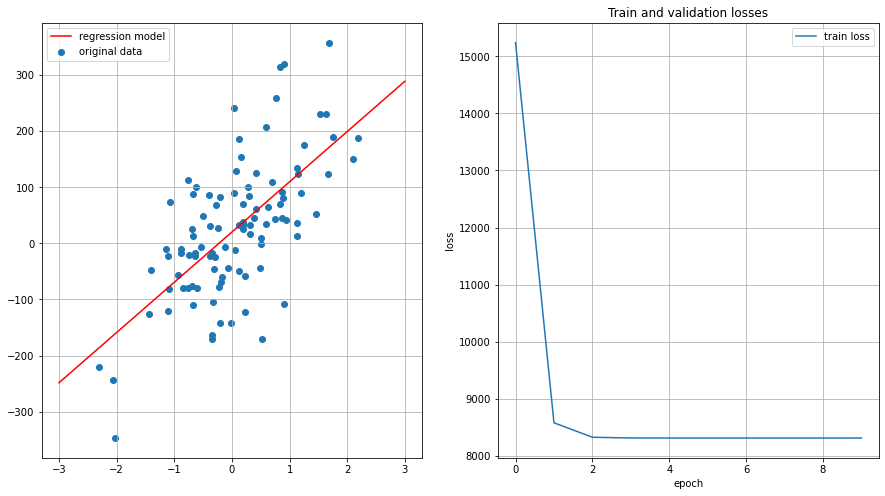

In [70]:
def make_dataset(n_features, n_informative, test_size=None, random_state=1):
    
    n_redundant = n_features - n_informative

    data = make_regression(n_features=n_features,
                           n_informative=n_informative,
                           noise=100.0,
                           random_state=random_state)
    
    x_train = data[0]
    y_train = data[1]
    if test_size:
        if test_size < 0 or test_size > 1: raise Exception('Invalid test size')
            
        n = int(x_train.shape[0] * test_size)
        x_val, y_val = x_train[:n], y_train[:n]
        x_train, y_train = x_train[n:], y_train[n:]
        return (x_train, y_train), (x_val, y_val)
    
    return (x_train, y_train)

x_train, y_train = make_dataset(n_features=1, n_informative=1, random_state=1)

model = LinearReg(gd_type='full')
model.fit(x_train, y_train)


x = np.arange(-3, 4)
y = x*model.w + model.w0

epochs = []
losses = []
val_losses = []
for epoch, loss in enumerate(model.loss_history):
    epochs.append(epoch)
    losses.append(loss)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

axes[0].scatter(x_train.reshape(y_train.shape), y_train, label='original data')
axes[0].plot(x, y, color='r', label='regression model')
axes[0].grid()
axes[0].legend()

axes[1].set_title('Train and validation losses')
axes[1].plot(epochs, losses, label='train loss')
axes[1].grid()
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('loss')
axes[1].legend()

** Задание 4 (0 баллов)**. 
* Загрузите данные из домашнего задания 2 ([train.csv](https://www.kaggle.com/c/nyc-taxi-trip-duration/data));
* Разбейте выборку на обучающую и тестовую в отношении 7:3 с random_seed=0;
* Преобразуйте целевую переменную `trip_duration` как $\hat{y} = \log{(y + 1)}$.

In [3]:
data = pd.read_csv('data/practice2/train.csv')
data['log_trip_duration'] = np.log(data['trip_duration'] + 1)
data.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag'], axis=1, inplace=True)
x_train, x_test, y_train, y_test = train_test_split(data.drop(['log_trip_duration', 'trip_duration'], axis=1),
                                                    data['log_trip_duration'],
                                                    test_size=0.3,
                                                    random_state=0)

** Задание 5 (3 балла)**. Обучите и провалидируйте модели на данных из предыдущего пункта, сравните качество между методами по метрикам MSE и $R^2$. Исследуйте влияние параметров `max_iter` и `eta` (`max_iter`, `alpha` и `eta` для Momentum) на процесс оптимизации. Согласуется ли оно с вашими ожиданиями?

In [73]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

model_full = LinearReg(gd_type='full')
model_full.fit(x_train, y_train)

C:\Users\sqrte\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in square
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-69-bc75b7c24a6c>:44: RuntimeWarning: invalid value encountered in double_scalars
  if np.abs(self.loss_history[-1] - self.loss_history[-2]) < self.tolerance:
<ipython-input-69-bc75b7c24a6c>:40: RuntimeWarning: invalid value encountered in double_scalars
  self.w0 += self.eta * w0_grad


LinearReg(gd_type='full', w0=nan)

In [5]:
# imports
import numpy as np


class LinearRegressionUsingGD:
    """Linear Regression Using Gradient Descent.
    Parameters
    ----------
    eta : float
        Learning rate
    n_iterations : int
        No of passes over the training set
    Attributes
    ----------
    w_ : weights/ after fitting the model
    cost_ : total error of the model after each iteration
    """

    def __init__(self, eta=0.05, n_iterations=1000):
        self.eta = eta
        self.n_iterations = n_iterations

    def fit(self, x, y):
        """Fit the training data
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Training samples
        y : array-like, shape = [n_samples, n_target_values]
            Target values
        Returns
        -------
        self : object
        """

        self.cost_ = []
        self.w_ = np.zeros((x.shape[1], 1))
        m = x.shape[0]

        for i in range(self.n_iterations):
            y_pred = np.dot(x, self.w_)
            print('y_pred shape: {}, y shape: {}, iteration: {}'.format(y_pred.shape, y.ravel().shape, i))
            residuals = y_pred - y.ravel()
            gradient_vector = np.dot(x.T, residuals)
            self.w_ -= (self.eta / m) * gradient_vector
            cost = np.sum((residuals ** 2)) / (2 * m)
            self.cost_.append(cost)
        return self

    def predict(self, x):
        """ Predicts the value after the model has been trained.
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Test samples
        Returns
        -------
        Predicted value
        """
        return np.dot(x, self.w_)

In [7]:
model_full = LinearRegressionUsingGD()
model_full.fit(x_train, y_train)
predictions = model_full.predict(x_test)
mean_squared_error(y_test, predictions)

y_pred shape: (1021050, 1), y shape: (1021050,), iteration: 0


MemoryError: Unable to allocate 7.59 TiB for an array with shape (1021050, 1021050) and data type float64

In [86]:
model_full.w_

array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

In [9]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)
pred = model.predict(x_test)
mean_squared_error(y_test, pred)

0.601890569100352

** Задание 6 (2 балла)**. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для полного, стохастического градиентного спусков, а также для полного градиентного спуска с методом Momentum. Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Не забывайте о том, что должны получиться *красивые* графики!

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

### Бонус 

** Задание 7 (2 балла)**. Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью метода
[Adam](https://arxiv.org/pdf/1412.6980.pdf) - добавьте при необходимости параметры в класс модели, повторите пункты 5 и 6 и сравните результаты. 

** Задание 8 (2 балла)**. Реализуйте линейную регрессию с функцией потерь
$$ L(\hat{y}, y) = log(cosh(\hat{y} - y)),$$

обучаемую с помощью градиентного спуска.

** Задание 9 (0.01 балла)**.  Вставьте картинку с вашим любимым мемом в этот Jupyter Notebook